In [7]:
import pandas as pd  
df = pd.read_csv("synthetic_dirty_transaction_logs.csv").head(50)

In [8]:
print(df.head(5))

                                             raw_log
0  2025-07-05 19:18:10::user1069::withdrawal::299...
1                                                NaN
2                                      MALFORMED_LOG
3  usr:user1076|cashout|€4821.85|Glasgow|2025-07-...
4  2025-07-20 05:38:14 >> [user1034] did top-up -...


In [9]:
df.to_csv("first50_rows.csv", index=False)

In [1]:
import pandas as pd
import re
from datetime import datetime
import numpy as np

def clean_transaction_logs(csv_file_path=None, raw_data=None):
    """
    Clean transaction log data from various formats and return a structured DataFrame.
    
    Parameters:
    csv_file_path (str): Path to CSV file containing raw transaction logs
    raw_data (str): Raw string data if not reading from file
    
    Returns:
    pd.DataFrame: Cleaned transaction data with standardized columns
    """
    
    # Read data
    if csv_file_path:
        with open(csv_file_path, 'r', encoding='utf-8') as file:
            raw_content = file.read()
    elif raw_data:
        raw_content = raw_data
    else:
        raise ValueError("Either csv_file_path or raw_data must be provided")
    
    # Split into lines and filter out empty/invalid lines
    lines = raw_content.split('\n')
    valid_lines = [
        line.strip() for line in lines 
        if line.strip() and 
        line.strip() not in ['""', 'MALFORMED_LOG', 'raw_log'] and
        not line.strip().startswith('raw_log')
    ]
    
    cleaned_records = []
    
    for idx, line in enumerate(valid_lines):
        record = parse_transaction_line(line, idx + 1)
        if record:
            cleaned_records.append(record)
    
    # Convert to DataFrame
    df = pd.DataFrame(cleaned_records)
    
    # Ensure proper data types
    if not df.empty:
        df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
        df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
        df['row_id'] = df['row_id'].astype(int)
        
        # Fill NaN values appropriately
        df['location'] = df['location'].fillna('Unknown')
        df['device'] = df['device'].fillna('Unknown')
        df['currency'] = df['currency'].fillna('USD')
    
    return df

def parse_transaction_line(line, row_id):
    """
    Parse a single transaction log line and extract structured data.
    
    Parameters:
    line (str): Raw log line
    row_id (int): Row identifier
    
    Returns:
    dict: Parsed transaction data or None if parsing fails
    """
    
    if not line or line in ['""', 'MALFORMED_LOG']:
        return None
    
    record = {
        'row_id': row_id,
        'original_log': line,
        'datetime': None,
        'user_id': None,
        'transaction_type': None,
        'amount': None,
        'currency': None,
        'location': None,
        'device': None
    }
    
    try:
        # Pattern 1: Double colon format
        # 2025-07-05 19:18:10::user1069::withdrawal::2995.12::London::iPhone 13
        pattern1 = r'^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})::(\w+)::(\w+)::([\d,.]+)::([^:]+)::(.+)$'
        match = re.match(pattern1, line)
        if match:
            record.update({
                'datetime': parse_datetime(match.group(1)),
                'user_id': match.group(2),
                'transaction_type': match.group(3),
                'amount': extract_amount(match.group(4))['amount'],
                'currency': extract_amount(match.group(4))['currency'],
                'location': clean_field(match.group(5)),
                'device': clean_field(match.group(6))
            })
            return record
        
        # Pattern 2: Pipe separated format
        # usr:user1076|cashout|€4821.85|Glasgow|2025-07-15 12:56:05|Pixel 6
        pattern2 = r'^usr:(\w+)\|(\w+)\|([€£$]?[\d,.]+)\|([^|]+)\|(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\|(.+)$'
        match = re.match(pattern2, line)
        if match:
            amount_info = extract_amount(match.group(3))
            record.update({
                'user_id': match.group(1),
                'transaction_type': match.group(2),
                'amount': amount_info['amount'],
                'currency': amount_info['currency'],
                'location': clean_field(match.group(4)),
                'datetime': parse_datetime(match.group(5)),
                'device': clean_field(match.group(6))
            })
            return record
        
        # Pattern 3: Arrow format with brackets
        # 2025-07-20 05:38:14 >> [user1034] did top-up - amt=€2191.06 - None // dev:iPhone 13
        pattern3 = r'^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) >> \[(\w+)\] did ([\w-]+) - amt=([€£$]?[\d,.]+) - ([^/]+) // dev:(.+)$'
        match = re.match(pattern3, line)
        if match:
            amount_info = extract_amount(match.group(4))
            record.update({
                'datetime': parse_datetime(match.group(1)),
                'user_id': match.group(2),
                'transaction_type': match.group(3).replace('-', '_'),
                'amount': amount_info['amount'],
                'currency': amount_info['currency'],
                'location': clean_field(match.group(5)),
                'device': clean_field(match.group(6))
            })
            return record
        
        # Pattern 4: Pipe format with user/txn/device
        # 2025-07-29 23:47:37 | user: user1014 | txn: deposit of £3539.5 from Glasgow | device: iPhone 13
        pattern4 = r'^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) \| user: (\w+) \| txn: (\w+) of ([€£$]?[\d,.]+) from ([^|]+) \| device: (.+)$'
        match = re.match(pattern4, line)
        if match:
            amount_info = extract_amount(match.group(4))
            record.update({
                'datetime': parse_datetime(match.group(1)),
                'user_id': match.group(2),
                'transaction_type': match.group(3),
                'amount': amount_info['amount'],
                'currency': amount_info['currency'],
                'location': clean_field(match.group(5)),
                'device': clean_field(match.group(6))
            })
            return record
        
        # Pattern 5: Dash separated with user/action/ATM/device
        # 2025-06-23 14:45:58 - user=user1075 - action=debit $1215.74 - ATM: Leeds - device=Samsung Galaxy S10
        pattern5 = r'^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) - user=(\w+) - action=(\w+) ([€£$]?[\d,.]+) - ATM: ([^-]+) - device=(.+)$'
        match = re.match(pattern5, line)
        if match:
            amount_info = extract_amount(match.group(4))
            record.update({
                'datetime': parse_datetime(match.group(1)),
                'user_id': match.group(2),
                'transaction_type': match.group(3),
                'amount': amount_info['amount'],
                'currency': amount_info['currency'],
                'location': clean_field(match.group(5)),
                'device': clean_field(match.group(6))
            })
            return record
        
        # Pattern 6: Triple colon with asterisks (DD/MM/YYYY format)
        # 24/07/2025 22:47:06 ::: user1080 *** PURCHASE ::: amt:951.85$ @ Liverpool <Xiaomi Mi 11>
        pattern6 = r'^(\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}) ::: (\w+) \*\*\* (\w+) ::: amt:([€£$]?[\d,.]+) @ ([^<]+) <([^>]+)>$'
        match = re.match(pattern6, line)
        if match:
            amount_info = extract_amount(match.group(4))
            record.update({
                'datetime': parse_datetime(match.group(1)),
                'user_id': match.group(2),
                'transaction_type': match.group(3).lower(),
                'amount': amount_info['amount'],
                'currency': amount_info['currency'],
                'location': clean_field(match.group(5)),
                'device': clean_field(match.group(6))
            })
            return record
        
        # Pattern 7: Simple space-separated format
        # user1093 2025-07-05 14:11:06 withdrawal 4926.56 None Huawei P30
        pattern7 = r'^(\w+) (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) (\w+) ([\d,.]+) (\S+) (.+)$'
        match = re.match(pattern7, line)
        if match:
            record.update({
                'user_id': match.group(1),
                'datetime': parse_datetime(match.group(2)),
                'transaction_type': match.group(3),
                'amount': float(match.group(4).replace(',', '')),
                'currency': 'USD',  # Default when not specified
                'location': clean_field(match.group(5)),
                'device': clean_field(match.group(6))
            })
            return record
            
        # Pattern 8: Alternative triple colon format (DD/MM/YYYY)
        # 14/06/2025 07:25:39 ::: user1019 *** CASHOUT ::: amt:2428.72£ @ Leeds <iPhone 13>
        pattern8 = r'^(\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}) ::: (\w+) \*\*\* (\w+) ::: amt:([\d,.]+)([€£$]) @ ([^<]+) <([^>]+)>$'
        match = re.match(pattern8, line)
        if match:
            amount = float(match.group(4).replace(',', ''))
            currency_symbol = match.group(5)
            currency = get_currency_code(currency_symbol)
            record.update({
                'datetime': parse_datetime(match.group(1)),
                'user_id': match.group(2),
                'transaction_type': match.group(3).lower(),
                'amount': amount,
                'currency': currency,
                'location': clean_field(match.group(6)),
                'device': clean_field(match.group(7))
            })
            return record
            
    except Exception as e:
        print(f"Error parsing line {row_id}: {line[:50]}... - {str(e)}")
        return None
    
    return None

def parse_datetime(date_str):
    """Parse datetime string in various formats"""
    if not date_str or date_str.lower() == 'none':
        return None
    
    try:
        # Standard format: 2025-07-05 19:18:10
        if re.match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$', date_str):
            return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
        
        # DD/MM/YYYY format: 24/07/2025 22:47:06
        if re.match(r'^\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}$', date_str):
            return datetime.strptime(date_str, '%d/%m/%Y %H:%M:%S')
            
    except ValueError:
        print(f"Could not parse datetime: {date_str}")
    
    return None

def extract_amount(amount_str):
    """Extract amount and currency from amount string"""
    if not amount_str:
        return {'amount': None, 'currency': None}
    
    # Remove commas and extract numeric value
    amount_clean = re.sub(r'[^\d.,€£$]', '', str(amount_str))
    
    # Extract number
    number_match = re.search(r'([\d,]+\.?\d*)', amount_clean)
    if number_match:
        amount = float(number_match.group(1).replace(',', ''))
        
        # Detect currency
        currency = 'EUR'  # default
        if '€' in amount_str:
            currency = 'EUR'
        elif '£' in amount_str:
            currency = 'GBP'
        elif '$' in amount_str:
            currency = 'USD'
            
        return {'amount': amount, 'currency': currency}
    
    return {'amount': None, 'currency': None}

def get_currency_code(symbol):
    """Convert currency symbol to currency code"""
    currency_map = {
        '€': 'EUR',
        '£': 'GBP',
        '$': 'USD'
    }
    return currency_map.get(symbol, 'USD')

def clean_field(field):
    """Clean and standardize field values"""
    if not field or field.lower() in ['none', 'null', '']:
        return None
    return field.strip()

# Example usage and testing function
def test_cleaner():
    """Test the cleaner with sample data"""
    sample_data = """raw_log
    2025-07-05 19:18:10::user1069::withdrawal::2995.12::London::iPhone 13
    ""
    MALFORMED_LOG
    usr:user1076|cashout|€4821.85|Glasgow|2025-07-15 12:56:05|Pixel 6
    2025-07-20 05:38:14 >> [user1034] did top-up - amt=€2191.06 - None // dev:iPhone 13
    2025-06-13 10:04:51 >> [user1068] did deposit - amt=€1691.09 - Glasgow // dev:None
    2025-07-29 23:47:37 | user: user1014 | txn: deposit of £3539.5 from Glasgow | device: iPhone 13
    MALFORMED_LOG
    2025-06-23 14:45:58 - user=user1075 - action=debit $1215.74 - ATM: Leeds - device=Samsung Galaxy S10
    2025-07-31 06:50:50 | user: user1071 | txn: cashout of $1772.13 from None | device: Nokia 3310
    2025-07-07 20:42:12 - user=user1098 - action=deposit €304.0 - ATM: Birmingham - device=Nokia 3310
    24/07/2025 22:47:06 ::: user1080 *** PURCHASE ::: amt:951.85$ @ Liverpool <Xiaomi Mi 11>
    MALFORMED_LOG
    2025-06-10 20:06:30 >> [user1025] did withdrawal - amt=€3261.07 - London // dev:iPhone 13
    14/06/2025 07:25:39 ::: user1019 *** CASHOUT ::: amt:2428.72£ @ Leeds <iPhone 13>
    user1093 2025-07-05 14:11:06 withdrawal 4926.56 None Huawei P30"""
    
    # Clean the data
    df = clean_transaction_logs(raw_data=sample_data)
    
    # Display results
    print("Cleaned Transaction Data:")
    print("=" * 50)
    print(f"Total records processed: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst 5 records:")
    print(df.head())
    
    print("\nData types:")
    print(df.dtypes)
    
    print("\nUnique transaction types:")
    print(df['transaction_type'].value_counts())
    
    print("\nCurrency distribution:")
    print(df['currency'].value_counts())
    
    return df

# Run test if script is executed directly
if __name__ == "__main__":
    df = test_cleaner()

Cleaned Transaction Data:
Total records processed: 12
Columns: ['row_id', 'original_log', 'datetime', 'user_id', 'transaction_type', 'amount', 'currency', 'location', 'device']

First 5 records:
   row_id                                       original_log  \
0       1  2025-07-05 19:18:10::user1069::withdrawal::299...   
1       2  usr:user1076|cashout|€4821.85|Glasgow|2025-07-...   
2       3  2025-07-20 05:38:14 >> [user1034] did top-up -...   
3       4  2025-06-13 10:04:51 >> [user1068] did deposit ...   
4       5  2025-07-29 23:47:37 | user: user1014 | txn: de...   

             datetime   user_id transaction_type   amount currency location  \
0 2025-07-05 19:18:10  user1069       withdrawal  2995.12      EUR   London   
1 2025-07-15 12:56:05  user1076          cashout  4821.85      EUR  Glasgow   
2 2025-07-20 05:38:14  user1034           top_up  2191.06      EUR  Unknown   
3 2025-06-13 10:04:51  user1068          deposit  1691.09      EUR  Glasgow   
4 2025-07-29 23:47:37  us

In [2]:
from pathlib import Path

In [3]:
def test_cleaner():
    """Test the cleaner with sample data"""
    # repo_root = Path().resolve().parent  # or just Path().resolve()
    # print(repo_root)
    file_path = "first50_rows.csv"

    # Clean the data
    df = clean_transaction_logs(csv_file_path=file_path)
    
    # Display results
    print("Cleaned Transaction Data:")
    print("=" * 50)
    print(f"Total records processed: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst 5 records:")
    print(df.head())
    
    print("\nData types:")
    print(df.dtypes)
    
    print("\nUnique transaction types:")
    print(df['transaction_type'].value_counts())
    
    print("\nCurrency distribution:")
    print(df['currency'].value_counts())
    
    return df

if __name__ == "__main__":
    df = test_cleaner()

Cleaned Transaction Data:
Total records processed: 34
Columns: ['row_id', 'original_log', 'datetime', 'user_id', 'transaction_type', 'amount', 'currency', 'location', 'device']

First 5 records:
   row_id                                       original_log  \
0       1  2025-07-05 19:18:10::user1069::withdrawal::299...   
1       2  usr:user1076|cashout|€4821.85|Glasgow|2025-07-...   
2       3  2025-07-20 05:38:14 >> [user1034] did top-up -...   
3       4  2025-06-13 10:04:51 >> [user1068] did deposit ...   
4       5  2025-07-29 23:47:37 | user: user1014 | txn: de...   

             datetime   user_id transaction_type   amount currency location  \
0 2025-07-05 19:18:10  user1069       withdrawal  2995.12      EUR   London   
1 2025-07-15 12:56:05  user1076          cashout  4821.85      EUR  Glasgow   
2 2025-07-20 05:38:14  user1034           top_up  2191.06      EUR  Unknown   
3 2025-06-13 10:04:51  user1068          deposit  1691.09      EUR  Glasgow   
4 2025-07-29 23:47:37  us

In [4]:
df

,row_id,original_log,datetime,user_id,transaction_type,amount,currency,location,device
0,1,2025-07-05 19:18:10::user1069::withdrawal::299...,2025-07-05 19:18:10,user1069,withdrawal,2995.12,EUR,London,iPhone 13
1,2,usr:user1076|cashout|€4821.85|Glasgow|2025-07-...,2025-07-15 12:56:05,user1076,cashout,4821.85,EUR,Glasgow,Pixel 6
2,3,2025-07-20 05:38:14 >> [user1034] did top-up -...,2025-07-20 05:38:14,user1034,top_up,2191.06,EUR,Unknown,iPhone 13
3,4,2025-06-13 10:04:51 >> [user1068] did deposit ...,2025-06-13 10:04:51,user1068,deposit,1691.09,EUR,Glasgow,Unknown
4,5,2025-07-29 23:47:37 | user: user1014 | txn: de...,2025-07-29 23:47:37,user1014,deposit,3539.50,GBP,Glasgow,iPhone 13
5,6,2025-06-23 14:45:58 - user=user1075 - action=d...,2025-06-23 14:45:58,user1075,debit,1215.74,USD,Leeds,Samsung Galaxy S10
6,7,2025-07-31 06:50:50 | user: user1071 | txn: ca...,2025-07-31 06:50:50,user1071,cashout,1772.13,USD,Unknown,Nokia 3310
7,8,2025-07-07 20:42:12 - user=user1098 - action=d...,2025-07-07 20:42:12,user1098,deposit,304.00,EUR,Birmingham,Nokia 3310
8,9,24/07/2025 22:47:06 ::: user1080 *** PURCHASE ...,2025-07-24 22:47:06,user1080,purchase,951.85,USD,Liverpool,Xiaomi Mi 11
9,10,2025-06-10 20:06:30 >> [user1025] did withdraw...,2025-06-10 20:06:30,user1025,withdrawal,3261.07,EUR,London,iPhone 13


In [5]:
def test_cleaner():
    """Test the cleaner with sample data"""
    # repo_root = Path().resolve().parent  # or just Path().resolve()
    # print(repo_root)
    file_path = "synthetic_dirty_transaction_logs.csv"

    # Clean the data
    df = clean_transaction_logs(csv_file_path=file_path)
    
    # Display results
    print("Cleaned Transaction Data:")
    print("=" * 50)
    print(f"Total records processed: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst 5 records:")
    print(df.head())
    
    print("\nData types:")
    print(df.dtypes)
    
    print("\nUnique transaction types:")
    print(df['transaction_type'].value_counts())
    
    print("\nCurrency distribution:")
    print(df['currency'].value_counts())
    
    return df

if __name__ == "__main__":
    df = test_cleaner()

Cleaned Transaction Data:
Total records processed: 6904
Columns: ['row_id', 'original_log', 'datetime', 'user_id', 'transaction_type', 'amount', 'currency', 'location', 'device']

First 5 records:
   row_id                                       original_log  \
0       1  2025-07-05 19:18:10::user1069::withdrawal::299...   
1       2  usr:user1076|cashout|€4821.85|Glasgow|2025-07-...   
2       3  2025-07-20 05:38:14 >> [user1034] did top-up -...   
3       4  2025-06-13 10:04:51 >> [user1068] did deposit ...   
4       5  2025-07-29 23:47:37 | user: user1014 | txn: de...   

             datetime   user_id transaction_type   amount currency location  \
0 2025-07-05 19:18:10  user1069       withdrawal  2995.12      EUR   London   
1 2025-07-15 12:56:05  user1076          cashout  4821.85      EUR  Glasgow   
2 2025-07-20 05:38:14  user1034           top_up  2191.06      EUR  Unknown   
3 2025-06-13 10:04:51  user1068          deposit  1691.09      EUR  Glasgow   
4 2025-07-29 23:47:37  

In [6]:
print(df.shape)

(6904, 9)


In [7]:
df.tail()

,row_id,original_log,datetime,user_id,transaction_type,amount,currency,location,device
6899,7770,usr:user1058|debit|£3992.06|Leeds|2025-06-10 0...,2025-06-10 03:55:41,user1058,debit,3992.06,GBP,Leeds,Pixel 6
6900,7771,08/07/2025 08:50:09 ::: user1069 *** WITHDRAWA...,2025-07-08 08:50:09,user1069,withdrawal,1401.58,EUR,Birmingham,Nokia 3310
6901,7772,2025-07-31 07:41:34::user1024::deposit::1331.2...,2025-07-31 07:41:34,user1024,deposit,1331.20,EUR,Cardiff,Nokia 3310
6902,7773,2025-06-23 05:14:03 >> [user1029] did withdraw...,2025-06-23 05:14:03,user1029,withdrawal,4203.63,GBP,London,Xiaomi Mi 11
6903,7774,2025-07-27 17:57:22::user1048::refund::2988.49...,2025-07-27 17:57:22,user1048,refund,2988.49,EUR,Leeds,Xiaomi Mi 11


In [8]:
df.loc[df['user_id'].str.contains("user")]

,row_id,original_log,datetime,user_id,transaction_type,amount,currency,location,device
0,1,2025-07-05 19:18:10::user1069::withdrawal::299...,2025-07-05 19:18:10,user1069,withdrawal,2995.12,EUR,London,iPhone 13
1,2,usr:user1076|cashout|€4821.85|Glasgow|2025-07-...,2025-07-15 12:56:05,user1076,cashout,4821.85,EUR,Glasgow,Pixel 6
2,3,2025-07-20 05:38:14 >> [user1034] did top-up -...,2025-07-20 05:38:14,user1034,top_up,2191.06,EUR,Unknown,iPhone 13
3,4,2025-06-13 10:04:51 >> [user1068] did deposit ...,2025-06-13 10:04:51,user1068,deposit,1691.09,EUR,Glasgow,Unknown
4,5,2025-07-29 23:47:37 | user: user1014 | txn: de...,2025-07-29 23:47:37,user1014,deposit,3539.50,GBP,Glasgow,iPhone 13
...,...,...,...,...,...,...,...,...,...
6899,7770,usr:user1058|debit|£3992.06|Leeds|2025-06-10 0...,2025-06-10 03:55:41,user1058,debit,3992.06,GBP,Leeds,Pixel 6
6900,7771,08/07/2025 08:50:09 ::: user1069 *** WITHDRAWA...,2025-07-08 08:50:09,user1069,withdrawal,1401.58,EUR,Birmingham,Nokia 3310
6901,7772,2025-07-31 07:41:34::user1024::deposit::1331.2...,2025-07-31 07:41:34,user1024,deposit,1331.20,EUR,Cardiff,Nokia 3310
6902,7773,2025-06-23 05:14:03 >> [user1029] did withdraw...,2025-06-23 05:14:03,user1029,withdrawal,4203.63,GBP,London,Xiaomi Mi 11


In [9]:
df['user_id'] = df['user_id'].apply(lambda x: int(x.replace("user", "")))

In [10]:
df.head()

,row_id,original_log,datetime,user_id,transaction_type,amount,currency,location,device
0,1,2025-07-05 19:18:10::user1069::withdrawal::299...,2025-07-05 19:18:10,1069,withdrawal,2995.12,EUR,London,iPhone 13
1,2,usr:user1076|cashout|€4821.85|Glasgow|2025-07-...,2025-07-15 12:56:05,1076,cashout,4821.85,EUR,Glasgow,Pixel 6
2,3,2025-07-20 05:38:14 >> [user1034] did top-up -...,2025-07-20 05:38:14,1034,top_up,2191.06,EUR,Unknown,iPhone 13
3,4,2025-06-13 10:04:51 >> [user1068] did deposit ...,2025-06-13 10:04:51,1068,deposit,1691.09,EUR,Glasgow,Unknown
4,5,2025-07-29 23:47:37 | user: user1014 | txn: de...,2025-07-29 23:47:37,1014,deposit,3539.50,GBP,Glasgow,iPhone 13


In [11]:
df['user_id'].value_counts()

user_id
1020    221
1081    175
1087    172
1027    164
1048    157
       ... 
1072     31
1065     31
1006     29
1088     28
1041     28
Name: count, Length: 86, dtype: int64

In [12]:
df.groupby("user_id")["amount"].mean().round(3).sort_values(ascending=False)

user_id
1074    2848.129
1049    2750.199
1080    2735.680
1055    2709.141
1092    2705.398
          ...   
1038    2181.996
1088    2097.350
1015    2094.902
1001    2087.653
1006    1990.137
Name: amount, Length: 86, dtype: float64

In [15]:
print(df[df['user_id'] == 1074]['amount'].min())

50.87


In [41]:
sns.set_palette("deep")
# sns.set_palette("muted")
# sns.set_palette("pastel")
# sns.set_palette("bright")
# sns.set_palette("dark")
# sns.set_palette("colorblind")

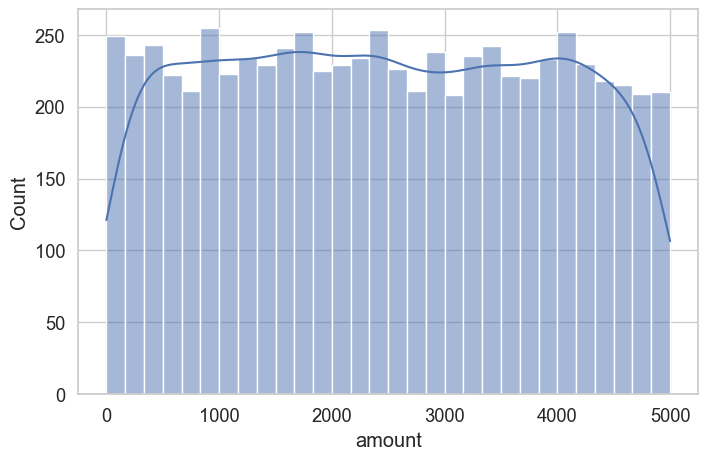

✅ Chart saved to: c:\Users\user\Desktop\moniepoint\charts\amount_histogram.png


In [42]:
save_chart(
    fig_name="amount_histogram",
    plot_func=sns.histplot,
    data=df,
    x="amount",
    bins=30,
    kde=True
)

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd

data = {
    'customer_id': ['C001','C001','C001','C002','C002'],
    'transaction_date': ['2025-08-01','2025-08-03','2025-08-06','2025-08-01','2025-08-09'],
    'amount': [100, 50, 200, 300, 150]
}
df = pd.DataFrame(data)

# Convert to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Sort for group-wise calculation
df = df.sort_values(['customer_id', 'transaction_date'])

# Use apply to keep index aligned
df['transaction_count_last_7_days'] = (
    df.groupby('customer_id')
      .apply(lambda g: g.rolling('7D', on='transaction_date')['amount'].count())
      .reset_index(level=0, drop=True)
)

print(df)

  customer_id transaction_date  amount  transaction_count_last_7_days
0        C001       2025-08-01     100                            1.0
1        C001       2025-08-03      50                            2.0
2        C001       2025-08-06     200                            3.0
3        C002       2025-08-01     300                            1.0
4        C002       2025-08-09     150                            1.0
